# PRISM PRECIP Datm Stream Analysis Notebook

This notebook provides methodologies for analyzing NEON/CTSM runs with PRISM precipitation compared to default NEON precipitation data streams.

Overview:
---------
The main components of this notebook cover the following:
- Cumulative precipitation plots comparing ground, NEON, and PRISM precip data
    - These figures can be used to determine varying magnitude of rainfall events in specific datasets and help inform decisions on what precipitation datm stream to use for a given site.
- Climatologies of energy and water fluxes
    - These can help inform users of expected fluxes and compare the ctsm/neon output created with NEON and PRISM precipitation with a 'ground truth' climatology.
- Bias map for summertime latent heat fluxes
    - Bias maps provide insight on how results from cases with both NEON and PRISM precipitation vary from expected values.


Authors:
--------
- Teagan King @TeaganKing (contributed some plotting scripts and adjusted scripts for NEON/PRISM precipitation comparison)
- Negin Sobhani @negin513 (contributed some plotting scripts)
- Will Wieder @wwieder (contributed some plotting scripts)
- Alison Post (provided ground based datasets from NOAA and SCAN)

In [1]:
#Import Libraries
%matplotlib inline

import calendar
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy import crs as ccrs, feature as cfeature
import cftime
import csv
import datetime
from datetime import datetime
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
import netCDF4
from netCDF4 import Dataset
import numpy as np
import openpyxl
import os
from os.path import join, expanduser
import pandas as pd
from scipy import stats
import sys
import time
import tqdm
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

Configuration information that will be carried throughout the notebook is below:

In [2]:
# The sites and years that the user wants to look at to compare NEON/PRISM output
site_list=['JORN']
year_list=['2018']

# ground based data files
# we have data for CPER, JORN, KONZ, NGOP, SJER, and SRER (some of which are complete, others have gaps)
JORN_SCAN_file = 'Daily_precip/JORN_SCAN_precip.xlsx'
JORN_NOAA_file = 'Daily_precip/JORN_NOAA_HQ_precip.xlsx'

# NEON/CTSM half hourly output with PRISM precip
half_hourly_files = '/glade/work/tking/ctsm_tking/tools/site_and_regional/JORN.transient/run/inputdata/atm/cdeps/v2/JORN/JORN_atm_2018-*.nc'

# PRISM precipitation csv files
prism_files_per_year = {'2018': 'PRISM_ppt_tmean_stable_4km_20180101_20181231.csv',
                        '2019': 'PRISM_ppt_tmean_stable_4km_20190101_20191231.csv',
                        '2020': 'PRISM_ppt_tmean_stable_4km_20200101_20201231.csv',
                        '2021': 'PRISM_ppt_tmean_stable_4km_20210101_20211231.csv',
                        '2022': 'PRISM_ppt_tmean_stable_4km_20220101_20220430.csv'}

# file that has lat/lon values of NEON sites
neon_sites_file = '/glade/scratch/wwieder/run_NEON_v2/tools/site_and_regional/neon_sites_dompft.csv'

# evaluation file directory
eval_dir = "/glade/work/wwieder/neon/eval_files/"

# cases with NEON precip data
neon_sim_path = "/glade/scratch/wwieder/NEON_testV2/archive/"

# cases with PRISM precip data
prism_sim_path = "/glade/work/tking/ctsm_tking/tools/site_and_regional/archive/"

# directories of preprocessed csv files
csv_preprocessed_dir_prism = "/glade/scratch/tking/preprocessed_neon/"
csv_preprocessed_dir_neon = "/glade/scratch/wwieder/preprocessed_neon_v2/"

# Compare NEON, PRISM, and ground-based precipitation data with daily and cumulative precipitation plots

These daily and cumulative precipitation figures can be used to determine varying magnitude of rainfall events in specific datasets and help inform decisions on what precipitation datm stream to use for a given site.

JORN is a site that we will not need to gap-fill with PRISM precip, according to Alison's summary spreadsheet, so we will focus on that site in this notebook for ease of use.

In [3]:
# read in ground based data:  ----------------
JORN_SCAN_data = pd.read_excel(JORN_SCAN_file) 
JORN_NOAA_data = pd.read_excel(JORN_NOAA_file)

# SCAN data
# Note that the first two rows are header info, title of column is 'unnamed'
# include 367 end index in order to look just at 2018
ground_scan_date = JORN_SCAN_data['Unnamed: 1'][2:367]
ground_scan_precip = JORN_SCAN_data['Unnamed: 2'][2:367]

# NOAA data
# Note that we only have 358 days of data in 2018 for NOAA
ground_noaa_date = JORN_NOAA_data['DATE'][:358]
ground_noaa_precip = JORN_NOAA_data['PRCP'][:358]

# read in NEON data --------------------------
half_hourly_neon_dataset = xr.open_mfdataset(half_hourly_files, parallel=True)

# resample NEON data to be daily
daily_neon_prect_dataset = half_hourly_neon_dataset['PRECTmms'].resample(time='1D').mean()

# get correct units (mm/s * (3600s/hr) * (24hr/day)  = mm/day)
daily_neon_prect = daily_neon_prect_dataset[:,0,0] * 3600 * 24 

# get prism data for JORN 2018 ----------------
pd.set_option('mode.chained_assignment', None)

# perform conversions and gather relevant data per site
section = {}
lat_dict={}
lon_dict={}
for site in site_list:
    for year in year_list:
        siteyear = site + year
        prism_df = pd.read_csv(prism_files_per_year[year], sep=';')
        
        # find relevant rows based on whether or not site is in cell
        section[siteyear] = prism_df[prism_df['PRISM Time Series Data'].str.contains(site)]

        new_df = section[siteyear]["PRISM Time Series Data"].str.split(",", expand = True)

        section[siteyear]["Precip"] = new_df[5]  # rain is 6th value, indexing starts at 0, so index #5
        section[siteyear]["Time"] = new_df[4]  # date is 5th value, indexing starts at 0, so index #4

        lat_dict[siteyear] = np.asarray(new_df[1])[0]
        lon_dict[siteyear] = np.asarray(new_df[2])[0]

        # Perform unit conversions
        section[siteyear]['Precip'] = section[siteyear]['Precip'].astype(float)
        
        # print(section[siteyear]['Time'])
        section[siteyear]['Time']  = section[siteyear]['Time']

# get prism time and precip values in distinguished arrays
prism_time_vals = section[siteyear]['Time']
prism_precip_vals = section[siteyear]['Precip']

# convert time array to proper format
prism_times=[]
for val in prism_time_vals:
    prism_times.append(datetime.strptime(val,'%Y-%m-%d'))


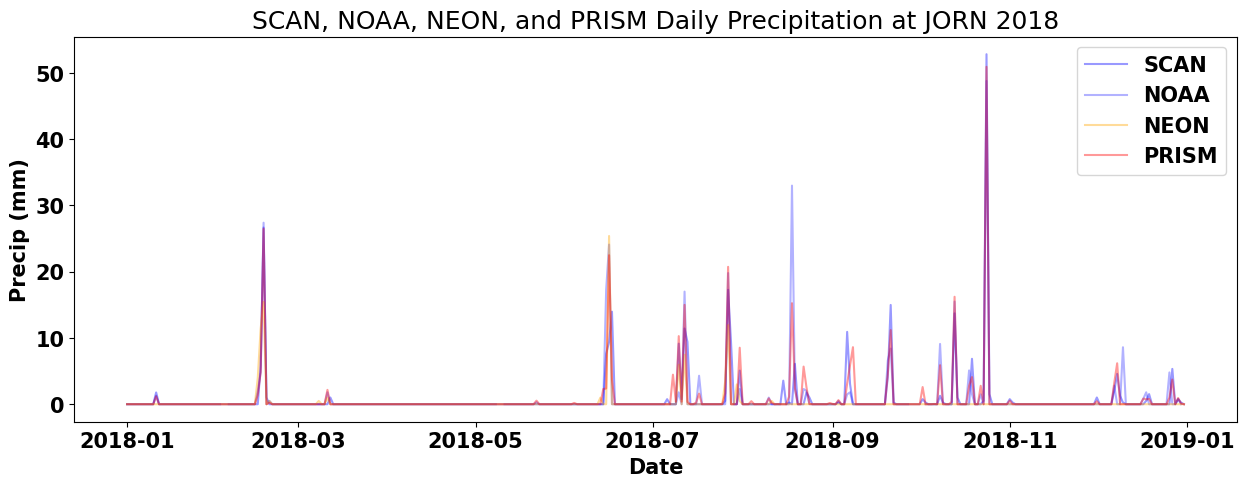

In [23]:
# Plot datasets
plt.plot(ground_scan_date, ground_scan_precip, label='SCAN', color='blue', alpha=0.4)
plt.plot(ground_noaa_date, ground_noaa_precip, label= 'NOAA', color='blue', alpha=0.3)
plt.plot(daily_neon_prect['time'], daily_neon_prect, label="NEON", color="orange", alpha=0.4)
plt.plot(prism_times,prism_precip_vals, label='PRISM', color='red', alpha=0.4)
plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel('Date')
plt.ylabel('Precip (mm)')
plt.title("SCAN, NOAA, NEON, and PRISM Daily Precipitation at {} {}".format(site_list[-1], year_list[-1]))
plt.legend()
plt.show()

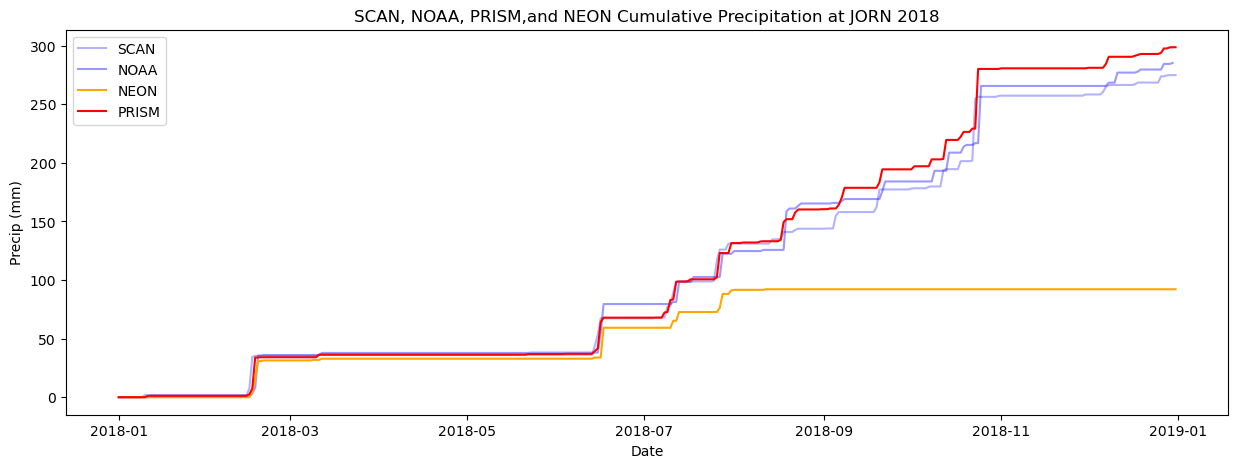

In [5]:
# Calendar year cumulative precipitation plots at JORN

cumulative_ground_scan_precip=[]
for index in range(2,366+1):
    cumulative_val = np.sum(ground_scan_precip.iloc[:index])
    cumulative_ground_scan_precip.append(cumulative_val)

cumulative_ground_noaa_precip=[]
for index in range(0,357+1):
    cumulative_val = np.sum(ground_noaa_precip.iloc[:index])
    cumulative_ground_noaa_precip.append(cumulative_val)

cumulative_prism_precip_vals=[]
for index in range(11325,11689+1):
    cumulative_val = np.sum(prism_precip_vals.loc[:index])
    cumulative_prism_precip_vals.append(cumulative_val)

# NEON data is in different format
daily_neon_prect_array = daily_neon_prect.compute()
cumulative_daily_neon_prect = []
for index in range(0,365):
    cumulative_val = np.sum(daily_neon_prect_array[:index])
    cumulative_daily_neon_prect.append(cumulative_val)

# Plot datasets
plt.plot(ground_scan_date, cumulative_ground_scan_precip, label='SCAN', color='blue', alpha=0.3)
plt.plot(ground_noaa_date, cumulative_ground_noaa_precip, label= 'NOAA', color='blue', alpha=0.4)
plt.plot(daily_neon_prect['time'], cumulative_daily_neon_prect, label="NEON", color="orange", alpha=1)
plt.plot(prism_times, cumulative_prism_precip_vals, label='PRISM', color='red', alpha=1)
plt.rcParams["figure.figsize"] = (15,5)
plt.xlabel('Date')
plt.ylabel('Precip (mm)')
plt.title("SCAN, NOAA, PRISM,and NEON Cumulative Precipitation at {} {}".format(site_list[-1], year_list[-1]))
plt.legend()
plt.show()


### Compare NEON and PRISM Precipitation against Expected Values with Climatology Plots of Energy and Water Fluxes

The following section is modified from the [NEON Flux Climatology Annual Flux climatology for PRISM and NEON precipitation notebook](https://github.com/wwieder/neon_scripts/blob/main/notebooks/prism_climatology.ipynb). In this section, we read in evaluation (NEON) and model data (CTSM with PRISM and NEON precipitation) and create climatology figures.

These can help inform users of expected fluxes and compare the ctsm/neon output created with NEON and PRISM precipitation with a 'ground truth' climatology.


In [6]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import calendar

import tqdm
import cftime

In [7]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

# the dashboard link below is useful to see how the dask workers are being used and examine CPU usage, etc

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:34732,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tking/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Various functions are defined below that will help create these climatology figures.

In [8]:
def shaded_tseries(df_daily, df_daily_std, var, ax, color1= '#e28743',color2='#1d657e',color3='red'):
    """Create a shaded timeseries"""
    
    plot_var = var.obs_var
    sim_var = var.sim_var
    prism_var = var.prism_var
    plot_var_desc = var.long_name
    plot_var_unit = var.unit
    
    ax.plot ( df_daily.time, df_daily[sim_var], marker = 'o' , linestyle ='dashed', color = color2, label="CTSM-NEON", alpha = 0.9)
    ax.plot ( df_daily.time, df_daily[prism_var], marker = 'o' , linestyle ='dashed', color = color3, label="CTSM-PRISM", alpha = 0.9)
    ax.plot ( df_daily.time, df_daily[plot_var], marker = 'o' , color = color1,label="NEON OBS.", alpha = 0.9)
    
    ax.fill_between(df_daily.time, df_daily[plot_var]-df_daily_std[plot_var], df_daily[plot_var]+df_daily_std[plot_var] ,
                    alpha=0.15, color = color1)
    ax.fill_between(df_daily.time, df_daily[sim_var]-df_daily_std[sim_var], df_daily[sim_var]+df_daily_std[sim_var] ,
                    alpha=0.15, color = color2)
    ax.fill_between(df_daily.time, df_daily[prism_var]-df_daily_std[prism_var], df_daily[prism_var]+df_daily_std[prism_var] ,
                    alpha=0.15, color = color3)

    ax.set_xlabel('Time', fontsize=17)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=17)
    ax.margins(x=0.02)


    
def climatology_tseries_allvars_fig3 (fig,  df_daily, df_daily_std, all_vars, 
                                      color1= '#e28743',color2='#1d657e', color3='red'):
    """Create a climatology plot with all variables"""
    
    panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]

    axes = fig.subplots(nrows=5, ncols=1)
    axe = axes.ravel()

    for index, var in enumerate(all_vars):
        ax = axe[index]

        shaded_tseries ( df_daily, df_daily_std, var, ax,color1,color2,color3)

        ax.text(.025,0.90,panel_labels[index],
            horizontalalignment='left',
            transform=ax.transAxes, fontweight='bold',fontsize=19)


        # Set the locator for boxplots
        locator = mdates.MonthLocator()  # every month

        # Specify the format - %b gives us Jan, Feb...
        fmt = mdates.DateFormatter('%b')            

        if index == 0:
            ax.text(.5,1.03,'NEON site : ' + neon_site + ' [2018-2021]',
            horizontalalignment='center',
            transform=ax.transAxes, fontweight='bold',fontsize=19)
            ax.legend(fontsize = 17)


        ax.tick_params(axis='both', which='both', labelsize=17,width=1,length=7)
        ax.tick_params(axis='x',direction="in", length = 7)
        ax.yaxis.set_ticks_position('both')
        ax.tick_params(axis='y',direction="out", length = 7)

        X=ax.xaxis
        X.set_major_locator(locator)
        X.set_major_formatter(fmt)

        ax.get_yaxis().set_label_coords(-0.05,0.5)

        if index == 5:
            X = plt.gca().xaxis
            X.set_major_locator(locator)
            X.set_major_formatter(fmt)

    ax.set_xlabel('Month', fontsize=17)
    fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()


In [9]:
class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name
    self.prism_var = 'prism_'+short_name

In [10]:
all_vars= [] 

plot_var = 'Rnet'
sim_var = 'sim_'+plot_var
prism_var = 'prism_'+plot_var
plot_var_desc = "Net Radiation"
plot_var_unit= "W m⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'FSH'
sim_var = 'sim_'+plot_var
prism_var = 'prism_'+plot_var
plot_var_desc = 'Sensible Heat Flux'
plot_var_unit= "W m⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'EFLX_LH_TOT'
sim_var = 'sim_'+plot_var
prism_var = 'prism_'+plot_var
plot_var_desc = "Latent Heat Flux"
plot_var_unit= "W m⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'GPP'
sim_var = 'sim_'+plot_var
prism_var = 'prism_'+plot_var
plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'NEE'
sim_var = 'sim_'+plot_var
prism_var = 'prism_'+plot_var
plot_var_desc = "Net Ecosystem Exchange"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

In [11]:
# -- read list of sites:
neon_sites_pft = pd.read_csv(neon_sites_file)
neon_sites = neon_sites_pft['Site'].to_list()

failed_sites = [] # -- list for saving failed sites

In [12]:
# -- read only these variables from the whole netcdf files
def preprocess (ds):
    variables = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

    ds_new= ds[variables]
    return ds_new

In [13]:
# -- fix timestamp on CTSM files so they can be matched with eval files
def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

In [14]:
## -- Setting some defaults for our figures:
plt.rcParams["font.weight"] = "bold"    
plt.rcParams["axes.labelweight"] = "bold"
font = {'weight' : 'bold',
        'size'   : 15} 
matplotlib.rc('font', **font)

---------------------------
Making plots for JORN
All simulation files for all years: [ 365 files]


Exception in thread Profile:
Traceback (most recent call last):
  File "/glade/u/home/tking/.conda/envs/neon/lib/python3.10/site-packages/distributed/profile.py", line 115, in process
    d = state["children"][ident]
KeyError: '_propagate_forgotten;/glade/u/home/tking/.conda/envs/neon/lib/python3.10/site-packages/distributed/scheduler.py;8196'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/glade/u/home/tking/.conda/envs/neon/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/glade/u/home/tking/.conda/envs/neon/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/glade/u/home/tking/.conda/envs/neon/lib/python3.10/site-packages/distributed/profile.py", line 274, in _watch
    process(frame, None, recent, omit=omit)
  File "/glade/u/home/tking/.conda/envs/neon/lib/python3.10/site-packages/distributed/profile.py", line 119, in process
    "de

Reading all simulation files took: 11.920405149459839 s.
All evaluation files for all years: [ 12 files]
Reading all observation files took: 0.29070425033569336 s.
Processing data...


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Making climatology plots...


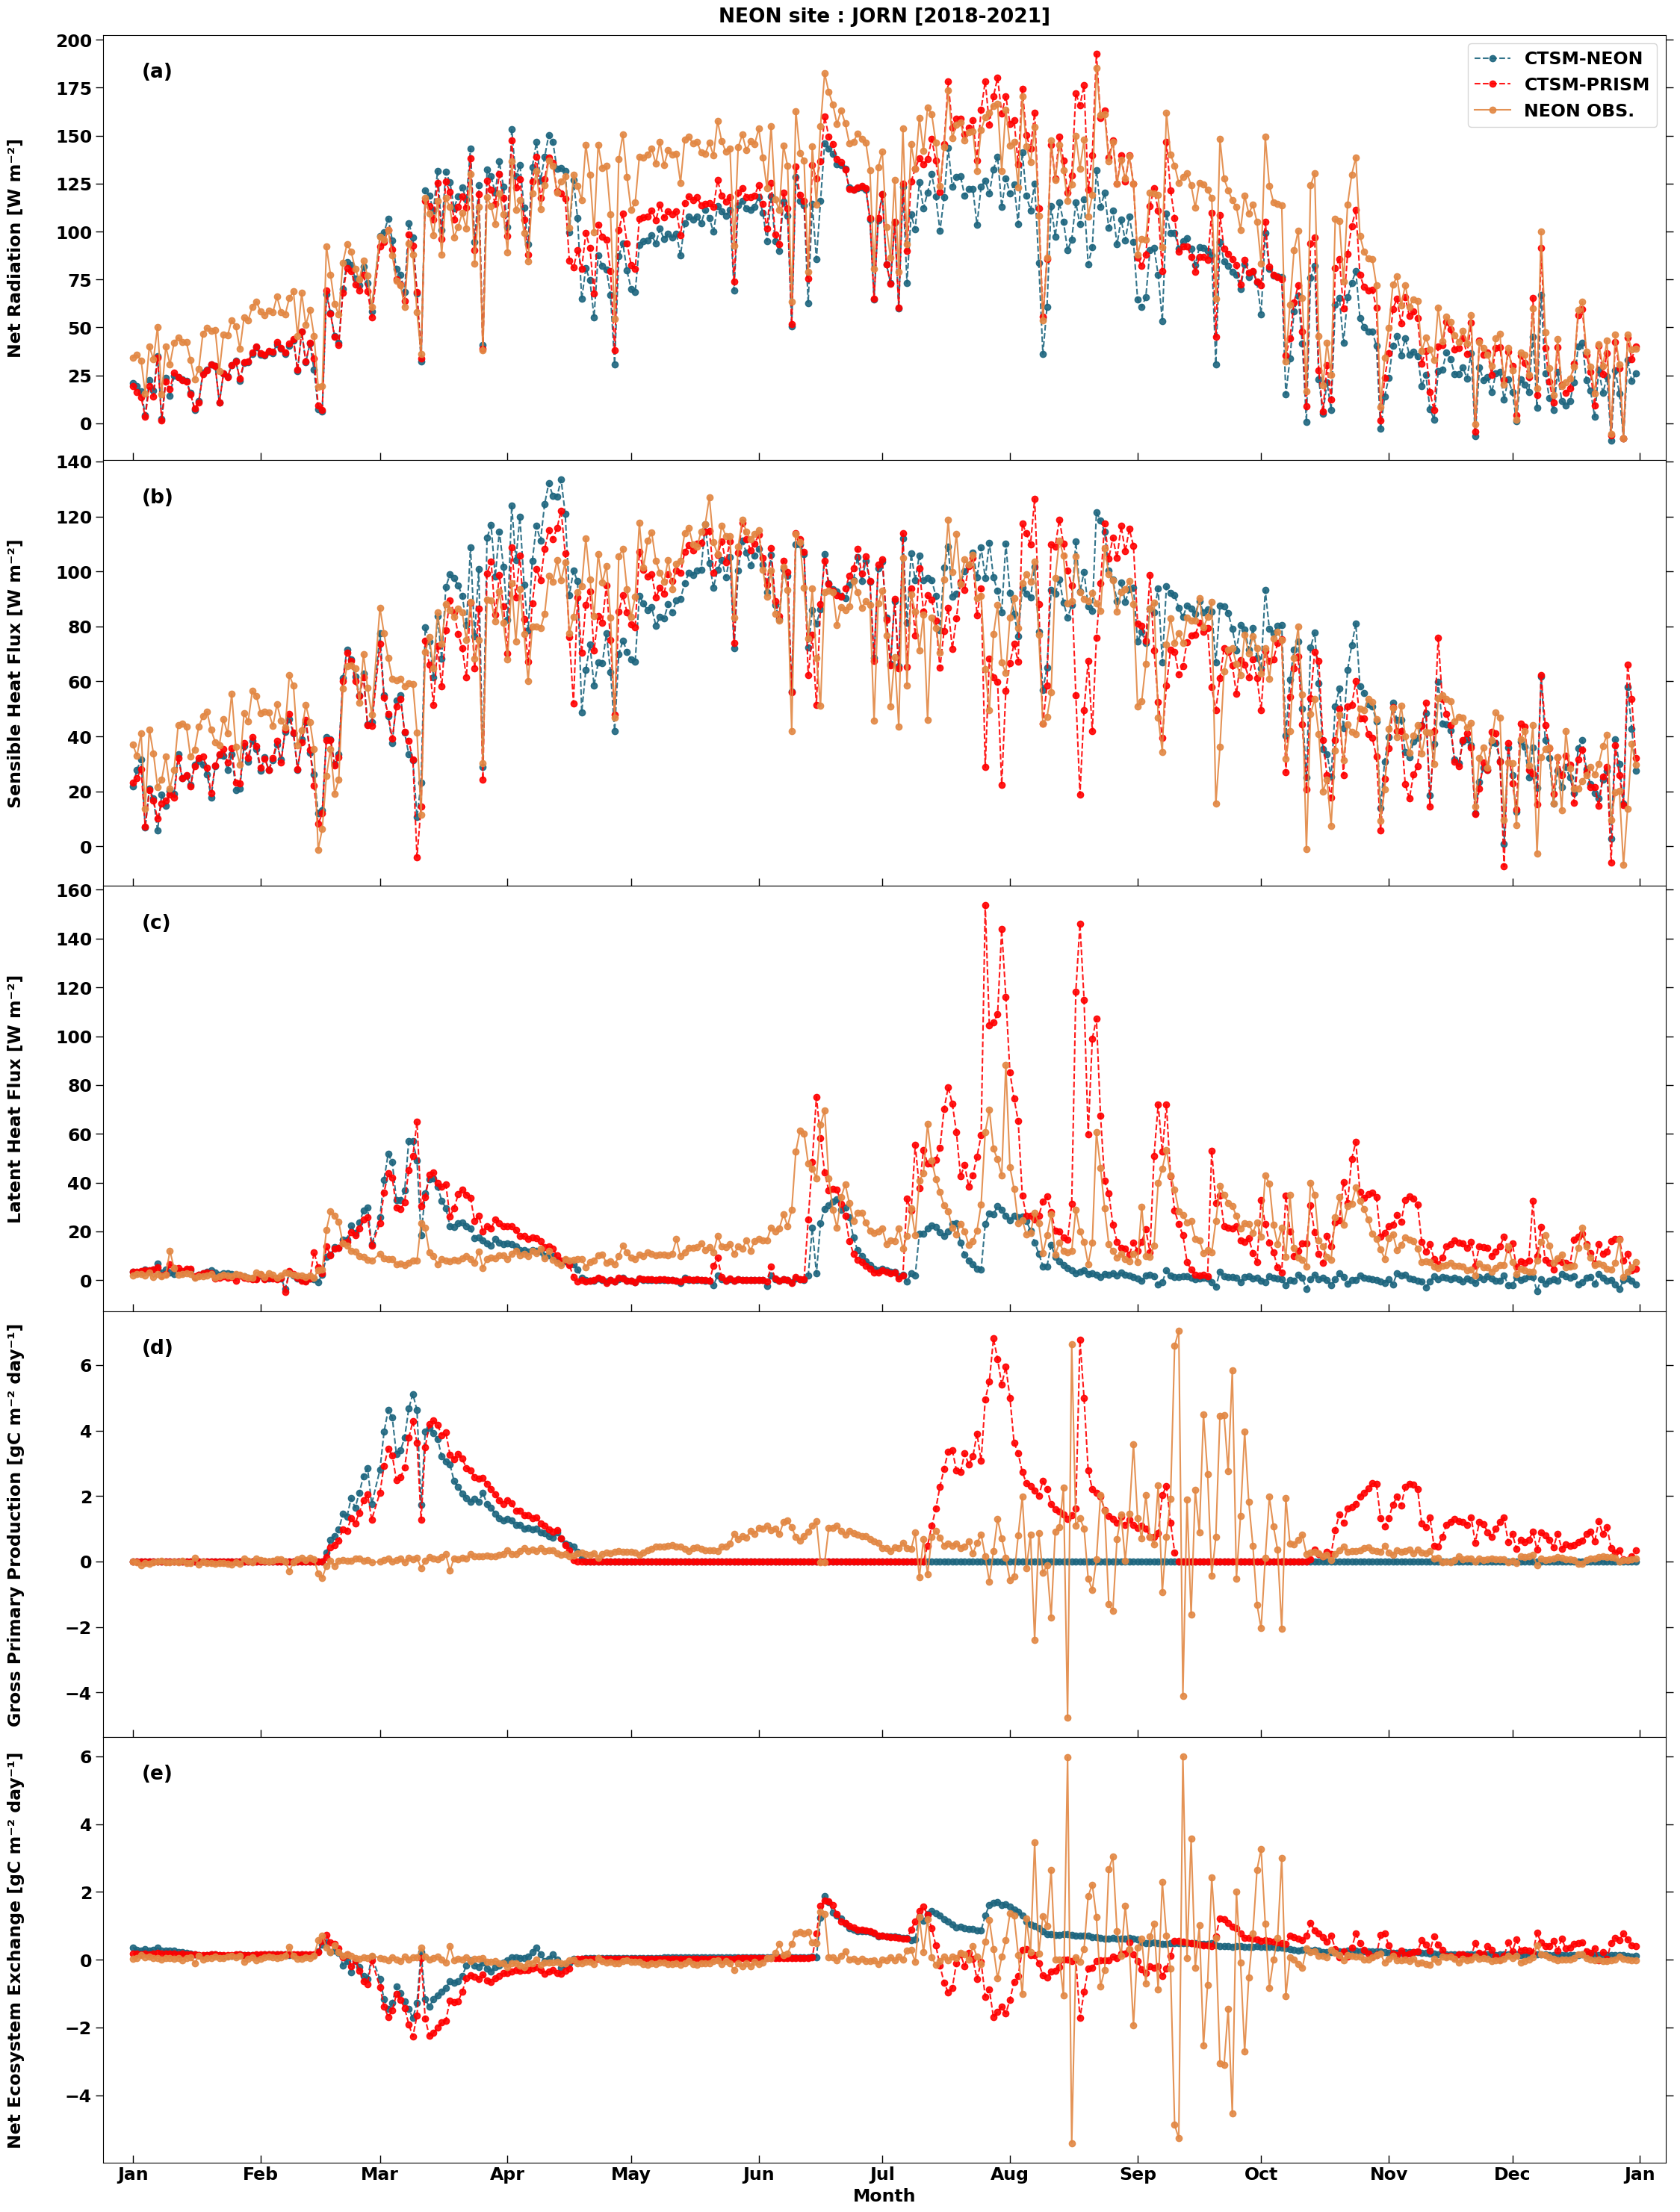

Making these plots for JORN took :  29.346203565597534 s.


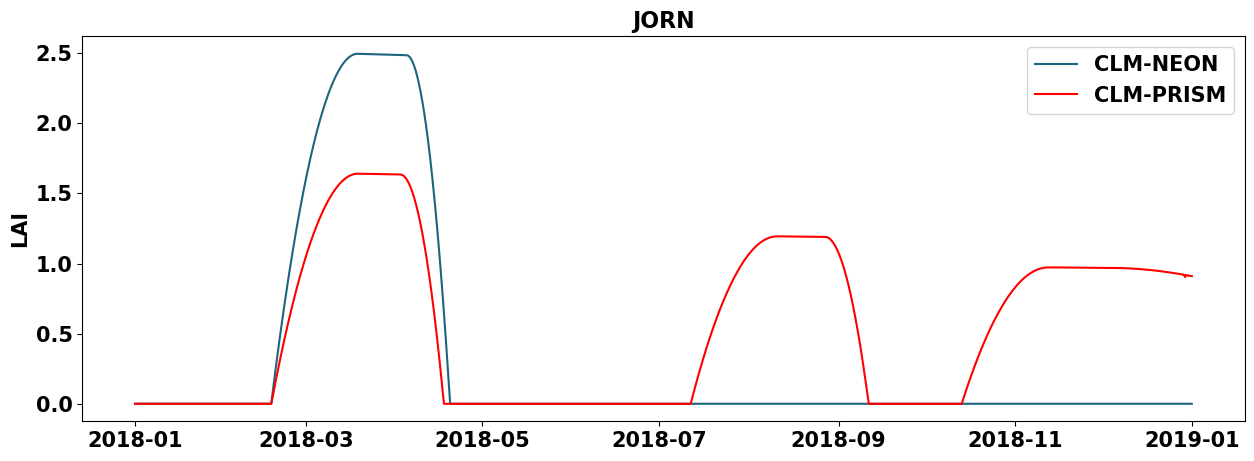

Number of sites failed: 0



In [15]:
for neon_site in site_list:
    try: 
        start_site = time.time()

        print ('---------------------------')
        print ("Making plots for "+neon_site)
        sim_files =[]
        sim_files2=[]
        for year in year_list:
            # cases with NEON precip data
            sim_path = neon_sim_path+neon_site+".transient/lnd/hist/"
            sim_files.extend(sorted(glob(join(sim_path,neon_site+".transient.clm2.h1."+year+"*.nc"))))

            # cases with PRISM precip data
            sim_path2 = prism_sim_path+neon_site+".transient/lnd/hist/"
            sim_files2.extend(sorted(glob(join(sim_path2,neon_site+".transient.clm2.h1."+year+"*.nc"))))

        print("All simulation files for all years: [", len(sim_files), "files]")
        start = time.time()

        ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, combine='by_coords',parallel=True,preprocess=preprocess)
        ds_ctsm = fix_time (ds_ctsm)

        ds_ctsm2 = xr.open_mfdataset(sim_files2, decode_times=True, combine='by_coords',parallel=True,preprocess=preprocess)
        ds_ctsm2 = fix_time (ds_ctsm2)

        end = time.time()
        print("Reading all simulation files took:", end-start, "s.")

        eval_files = []
        for year in year_list:
            eval_files.extend(sorted(glob(join(eval_dir+neon_site,neon_site+"_eval_"+year+"*.nc"))))

        print ("All evaluation files for all years: [", len(eval_files), "files]")

        start = time.time()

        ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')

        end = time.time()
        print("Reading all observation files took:", end-start, "s.")

        # =================================
        # Convert CTSM data to a Pandas Dataframe for easier handling:
        print ("Processing data...")
        ctsm_vars = ['FCEV', 'FCTR', 'FGEV','FSH','GPP','FSA','FIRA','AR','HR','ELAI']

        df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
        df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

        df_ctsm2 = pd.DataFrame({'time':ds_ctsm2.time})
        df_ctsm2['time'] = pd.to_datetime(df_ctsm2['time'],format= '%Y-%m-%d %H:%M:%S' )

        for var in tqdm.tqdm(ctsm_vars):
            sim_var_name = "sim_"+var
            field = np.ravel ( ds_ctsm[var])     
            df_ctsm[sim_var_name]=field
            #-- shift simulation data by one
            df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values

        # Repeat above for PRISM
        for var in tqdm.tqdm(ctsm_vars):
            sim_var_name = "prism_"+var
            field = np.ravel ( ds_ctsm2[var])     
            df_ctsm2[sim_var_name]=field
            #-- shift simulation data by one
            df_ctsm2[sim_var_name]=df_ctsm2[sim_var_name].shift(-1).values

        #Convert NEON data to a Pandas Dataframe for easier handling:
        eval_vars = ['NEE','FSH','EFLX_LH_TOT','GPP','Rnet']

        df_all = pd.DataFrame({'time':ds_eval.time})

        for var in eval_vars:
            field = np.ravel (ds_eval[var])
            df_all[var]=field
            
            
        # -- merge two pandas dataframe on time
        df_all=df_all.merge(df_ctsm.set_index('time'), on='time', how='left')
        # -- add prism data too
        df_all=df_all.merge(df_ctsm2.set_index('time'), on='time', how='left')

        
        # ===========================
        # sum up component fluxes

        # -- Latent Heat Flux:
        # -- EFLX_LH_TOT = FCEV + FCTR +FGEV
        clm_var = 'sim_EFLX_LH_TOT'
        df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

        # -- Net Radiation:
        # -- Rnet = FSA-FIRA
        clm_var = 'sim_Rnet'
        df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

        # -- Net Ecosystem Exchange
        # -- NEE = GPP- (AR+HR)
        # -- It seems like the sign are opposite so we calculated negative NEE
        clm_var = 'sim_NEE'
        df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

        # =============================
        # repeat for PRISM results
        # -- Latent Heat Flux:
        # -- EFLX_LH_TOT = FCEV + FCTR +FGEV
        clm_var = 'prism_EFLX_LH_TOT'
        df_all [clm_var] = df_all['prism_FCEV']+ df_all['prism_FCTR']+ df_all['prism_FGEV']

        # -- Net Radiation:
        # -- Rnet = FSA-FIRA
        clm_var = 'prism_Rnet'
        df_all [clm_var] = df_all ['prism_FSA']-df_all['prism_FIRA']

        # -- Net Ecosystem Exchange
        # -- NEE = GPP- (AR+HR)
        # -- It seems like the sign are opposite so we calculated negative NEE
        clm_var = 'prism_NEE'
        df_all [clm_var] = -(df_all ['prism_GPP']-(df_all['prism_AR']+df_all['prism_HR']))
        
        # convert NEE units from  umolm-2s-1 to gc/m2/s
        df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
        df_all ['GPP']= df_all ['GPP']*(12.01/1000000)
        
        # -- convert gc/m2/s to gc/m2/day
        df_all ['NEE']= df_all['NEE']*60*60*24
        df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24
        df_all ['prism_NEE']= df_all['prism_NEE']*60*60*24

        df_all ['GPP']= df_all['GPP']*60*60*24
        df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24
        df_all ['prism_GPP']= df_all['prism_GPP']*60*60*24

        #-- extract year, month, day, hour information from time
        df_all['year'] = df_all['time'].dt.year
        df_all['month'] = df_all['time'].dt.month
        df_all['day'] = df_all['time'].dt.day
        df_all['hour'] = df_all['time'].dt.hour

        #-- Calculate daily average for every day 
        df_daily_allyears = df_all.groupby(['year','month','day']).mean().reset_index()
        df_daily_allyears['time']=pd.to_datetime(df_daily_allyears[["year","month", "day"]])
        
        #-- Calculate average of daily averages for all years
        df_daily = df_daily_allyears.groupby(['month','day']).mean().reset_index()
        df_daily['year']='2020'
        df_daily['time']=pd.to_datetime(df_daily[["year","month", "day"]])

        #-- Calculate Standard Deviation of daily averages over years
        df_daily_std = df_daily_allyears.groupby(['month','day']).std().reset_index()
        df_daily_std['time'] = df_daily['time']

        #-- convert to local time
        tzone_shift = ds_eval.TimeDiffUtcLt
        df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))
        df_all['local_hour'] = df_all['local_time'].dt.hour

        #-- Calculate annual average diel cycle and bias
        diel_df_mean = df_all.groupby('local_hour').mean().reset_index()
        diel_df_std = df_all.groupby('local_hour').std().reset_index()
        diel_df_mean['local_hour_dt']= pd.to_datetime(diel_df_mean['local_hour'], format='%H')

        df_daily['site']=neon_site

        print ("Making climatology plots...")
        color1 = '#e28743'
        color2 = '#1d657e'
        color3 = 'red'
        #========================================================================        
        # Make the climatology times series
        fig = plt.figure(num=None, figsize=(27, 37),  facecolor='w', edgecolor='k')
        climatology_tseries_allvars_fig3(fig, df_daily, df_daily_std, all_vars, 
                                         color1, color2, color3)
        
        end_site = time.time()
        print("Making these plots for "+neon_site+" took : ", end_site-start_site, "s.")
        plt.show() 
        plt.close('all')

        # quick look at LAI
        plt.plot(df_all.time,df_all.sim_ELAI, color=color2,label='CLM-NEON')
        plt.plot(df_all.time,df_all.prism_ELAI, color=color3,label='CLM-PRISM')
        plt.ylabel('LAI')
        plt.title(neon_site, horizontalalignment='center', fontweight='bold',fontsize=16)
        plt.legend()
        plt.show() 
        plt.close('all')

    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass

print ("Number of sites failed:", len(failed_sites))
print (*failed_sites, sep=" \n")

### Spatial statitics

Before running the following cells, you should run neon_preprocessor to preprocess all neon simulation and evaluation files to csv.

In [16]:
# -- Functions for calculating stats
# Mean Absolute Error
def mae(predict, actual):
    """
    Examples(rounded for precision):
    >>> actual = [1,2,3];predict = [1,4,3]
    >>> np.around(mae(predict,actual),decimals = 2)
    0.67

    >>> actual = [1,1,1];predict = [1,1,1]
    >>> mae(predict,actual)
    0.0
    """
    predict = np.array(predict)
    actual = np.array(actual)
    d = {'predict':predict,'actual':actual}
    df = pd.DataFrame (d, columns =['predict','actual'])
    df= df.dropna()
    
    difference = abs(df['predict'] - df['actual'])
    score = difference.mean()

    return score


# Mean Squared Error
def mse(predict, actual):
    """
    Examples(rounded for precision):
    >>> actual = [1,2,3];predict = [1,4,3]
    >>> np.around(mse(predict,actual),decimals = 2)
    1.33

    >>> actual = [1,1,1];predict = [1,1,1]
    >>> mse(predict,actual)
    0.0
    """
    predict = np.array(predict)
    actual = np.array(actual)

    difference = predict - actual
    square_diff = np.square(difference)

    score = square_diff.mean()
    return score


# Mean Bias Deviation
def mbd(predict, actual):
    """
    This value is Negative, if the model underpredicts,
    positive, if it overpredicts.

    Example(rounded for precision):

    Here the model overpredicts
    >>> actual = [1,2,3];predict = [2,3,4]
    >>> np.around(mbd(predict,actual),decimals = 2)
    50.0

    Here the model underpredicts
    >>> actual = [1,2,3];predict = [0,1,1]
    >>> np.around(mbd(predict,actual),decimals = 2)
    -66.67
    """
    predict = np.array(predict)
    actual = np.array(actual)

    d = {'predict':predict,'actual':actual}
    df = pd.DataFrame (d, columns =['predict','actual'])
    df= df.dropna()
    
    
    difference = df['predict'] - df['actual']
    numerator = np.sum(difference) / len(df['predict'])
    denumerator = np.sum(df['actual']) / len(df['predict'])
    # print(numerator, denumerator)
    score = float(numerator) / denumerator * 100

    return score


def manual_accuracy(predict, actual):
    return np.mean(np.array(actual) == np.array(predict))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


# Root Mean Square Logarithmic Error
def rmsle(predict, actual):
    """
    Examples(rounded for precision):
    >>> actual = [10,10,30];predict = [10,2,30]
    >>> np.around(rmsle(predict,actual),decimals = 2)
    0.75

    >>> actual = [1,1,1];predict = [1,1,1]
    >>> rmsle(predict,actual)
    0.0
    """
    predict = np.array(predict)
    actual = np.array(actual)

    log_predict = np.log(predict + 1)
    log_actual = np.log(actual + 1)

    difference = log_predict - log_actual
    square_diff = np.square(difference)
    mean_square_diff = square_diff.mean()

    score = np.sqrt(mean_square_diff)

    return score

def MBE(y_true, y_pred):
    '''
    Parameters:
        y_true (array): Array of observed values
        y_pred (array): Array of prediction values

    Returns:
        mbe (float): Bias
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = y_true.reshape(len(y_true),1)
    y_pred = y_pred.reshape(len(y_pred),1)   
    diff = (y_pred-y_true)
    mbe = np.nanmean(diff)
    #print('MBE = ', mbe)
    return mbe

In [17]:
def plot_site_maps(df, plot_var, title, ax, vmin, vmax, cmap = "viridis"):

    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.LAKES, edgecolor='dimgray')

    ax.add_feature(cartopy.feature.LAND)

    ax.add_feature(cfeature.BORDERS, linewidth=0.9, edgecolor='dimgray')
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='dimgray')
    ax.add_feature(cfeature.COASTLINE)
    
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)

    
    # -- This plots all sites (for missing sites)
    plt.scatter(x=df.Lon, y=df.Lat,
                color='gray',
                s=80,
                alpha=1,
                transform=crs.PlateCarree()) ## Important

    sc = plt.scatter(x=df.Lon, y=df.Lat,
                c=df[plot_var],
                s=80,
                alpha=1,
                transform=crs.PlateCarree(), cmap=get_cmap(cmap), vmin = vmin, vmax= vmax, edgecolor='black', linewidth = 0.8) ## Important

    gl = ax.gridlines(
        draw_labels=False, linewidth=0.1, color='gray', alpha=0.5, linestyle='--'
    )
    
    gl.top_labels=False
    gl.right_labels=False

    gl.xlabel_style = { 'weight': 'bold', 'size':11}
    gl.ylabel_style = { 'weight': 'bold', 'size':11}

    ax.set_extent(extent)

    cax = fig.add_axes([ax.get_position().x1+0.021,ax.get_position().y0,0.013,ax.get_position().height])
    cbar = plt.colorbar(sc, extend='both',cax=cax)
    cbar.ax.tick_params(labelsize=12)

    ax.set_title(title, fontsize=16, fontweight='bold')

In [18]:
class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name

In [19]:
def get_bias_data (df, var, season):
    '''
    Get bias and other stats for a variable over a season or annual average.
    '''
    
    if (season != "Annual"):
        df_this = df[df['season']==season]
    else:
        df_this = df
    
    sim_var_name = "sim_"+var

    if var == 'NEE' or var == 'GPP':
        min_thresh = -100 * (12.01/1000000) *60*60*24
        max_thresh = 100 * (12.01/1000000) *60*60*24
    elif var == 'Rnet' or var == 'FSH' or var == 'EFLX_LH_TOT':
        min_thresh = -500
        max_thresh = 1000

    if var == 'ELAI':
        df = df_this
    else:
        #df, count = remove_outliers_manual (df_this, var, min_thresh, max_thresh)
        df = df_this

    neon_sites_2 = pd.read_csv(neon_sites_file)
    for i, row in neon_sites_2.iterrows():
        lat = row['Lat']
        lon = row['Lon']
        site = row['Site']

    cleaned = neon_sites_2[neon_sites_2['Site'].isin(neon_sites)].reset_index()

    mean_neon_var = 'mean_neon_'+var
    mean_clm_var = 'mean_clm_'+var
    bias_var = 'bias_'+var
    bias_score_var = 'bias_score_'+var
    rmse_var = 'rmse_'+var
    mae_var = 'mae_'+var
    mbd_var = 'mbd_'+var

    cleaned[mean_neon_var] = np.nan
    cleaned[mean_clm_var] = np.nan
    cleaned[bias_var] = np.nan
    cleaned[rmse_var] = np.nan
    cleaned[mae_var] = np.nan
    cleaned[mbd_var] = np.nan
    cleaned[bias_score_var] = np.nan

    for i, row in cleaned.iterrows():
        neon_site = cleaned['Site'][i]
    
        df_this = df[df['site']==neon_site]
    
        sim_var = 'sim_'+var
        
        this_rmse = rmse(df_this[sim_var], df_this[var])
        cleaned[rmse_var][i]= this_rmse
        
        this_mae = mae(df_this[sim_var], df_this[var])
        cleaned[mae_var][i]= this_mae
        
        this_mbd = mbd(df_this[sim_var], df_this[var])
        cleaned[mbd_var][i]= this_mbd
        
        this_neon_mean = df_this[var].mean()
        this_clm_mean = df_this[sim_var].mean()
        
        this_bias = MBE(df_this[var],df_this[sim_var])

        cleaned[mean_neon_var][i]= this_neon_mean
        cleaned[mean_clm_var][i]= this_clm_mean
        cleaned[bias_var][i]= this_bias

        this_bscore = (this_clm_mean - this_neon_mean)/this_rmse
        cleaned[bias_score_var][i]= this_bscore
        
    return cleaned

In [20]:
all_vars= [] 

plot_var = 'EFLX_LH_TOT'
sim_var = 'sim_'+plot_var
plot_var_desc = "Latent Heat Flux"
plot_var_unit= "Wm⁻²"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

# -- read list of sites:
neon_sites_pft = pd.read_csv(neon_sites_file)
neon_sites = neon_sites_pft['Site'].to_list()

## -- Setting some defaults for our figures:
plt.rcParams["font.weight"] = "bold"    
plt.rcParams["axes.labelweight"] = "bold"
font = {'weight' : 'bold',
        'size'   : 15} 
matplotlib.rc('font', **font)

failed_sites = [] # -- list for saving failed sites
df_list_prism =[]
df_list_neon =[]
start_site = time.time()

for neon_site in tqdm.tqdm(neon_sites):
    try: 
        csv_file = "preprocessed_"+neon_site+"*.csv"
        for f in glob((os.path.join(csv_preprocessed_dir_prism, csv_file))):
            this_df_prism = pd.read_csv(f)
        for f in glob((os.path.join(csv_preprocessed_dir_neon, csv_file))):
            this_df_neon = pd.read_csv(f)
        df_list_prism.append(this_df_prism)
        df_list_neon.append(this_df_neon)
        
    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass

df_all_neon = pd.concat(df_list_neon)
df_all_neon['season'] = ((df_all_neon['month']%12+3)//3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})

df_all_prism = pd.concat(df_list_prism)
df_all_prism['season'] = ((df_all_prism['month']%12+3)//3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})

end_site = time.time()
print("Reading all preprocessed files took:", end_site-start_site, "s.")

print ("Number of failed sites : ", len(failed_sites))
print (*failed_sites, sep=" \n")

100%|██████████| 47/47 [00:22<00:00,  2.12it/s]


Reading all preprocessed files took: 24.172934532165527 s.
Number of failed sites :  0



In [21]:
projPC = ccrs.PlateCarree()
lonW = -127
lonE = -67
latS = 20
latN = 55
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '110m'

central_lon = cLat
central_lat = cLon

central_lat = 37.5
central_lon = -96

extent = [-120, -70, 24, 50.5]

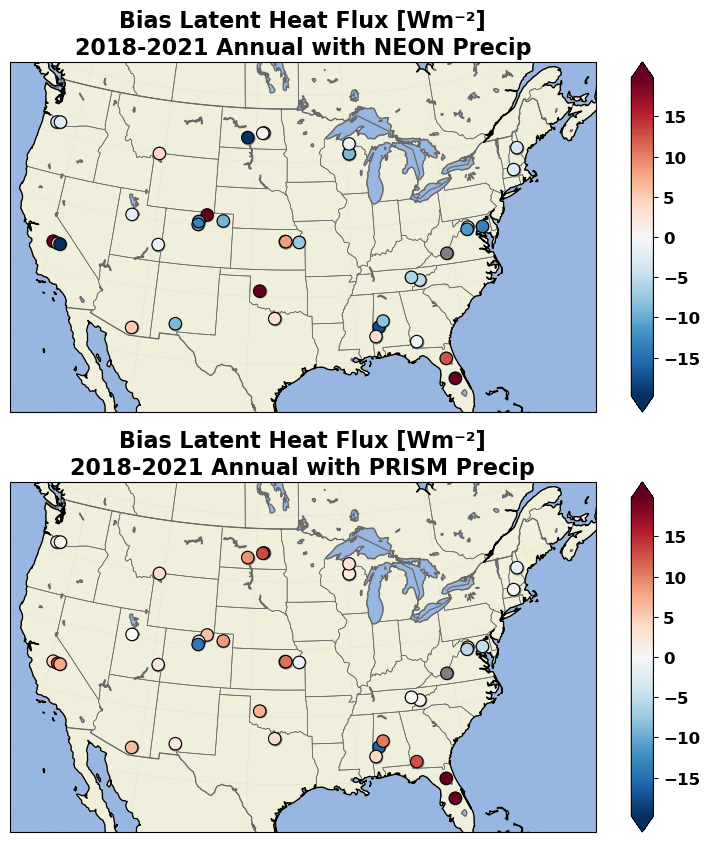

In [22]:
projection=ccrs.AlbersEqualArea(central_lon, central_lat)

seasons = ['Annual']
save_flag = False

for var in all_vars:
    plot_var = var.obs_var
    sim_var = var.sim_var
    plot_var_desc = var.long_name
    plot_var_unit = var.unit
    for season in seasons:

        fig = plt.figure(figsize=(17,10), facecolor='w', edgecolor='k')
        cmap = "YlOrBr"

        #----- NEON BIAS PLOT ------
        
        df_tmp = get_bias_data(df_all_neon, plot_var, season)

        ax = fig.add_subplot(2,1,1, projection=projection)
        this_var = 'bias_'+plot_var

        min_val = min(df_tmp[this_var])
        max_val = max(df_tmp[this_var])

        vmin = min_val
        vmax = -min_val
        cmap = matplotlib.cm.get_cmap('RdBu_r')

        title = "Bias "+ plot_var_desc+" ["+plot_var_unit+"]"+"\n"+"2018-2021"+ " " + season + " with NEON Precip"

        plot_site_maps(df_tmp, this_var, title, ax, vmin, vmax, cmap)

        #----- PRISM BIAS PLOT ------
        df_tmp = get_bias_data(df_all_prism, plot_var, season)

        ax = fig.add_subplot(2,1,2, projection=projection)
        this_var = 'bias_'+plot_var

        # keep same scale as NEON plot
        
        title = "Bias "+ plot_var_desc+" ["+plot_var_unit+"]"+"\n"+"2018-2021"+ " " + season + " with PRISM Precip"

        plot_site_maps(df_tmp, this_var, title, ax, vmin, vmax, cmap)


To Do:
------
- make utilities/functions
- make sure things work if gaps in ground data
- implement dask in first section
- for some reason, not including second set of imports is causing failures
- first section will currently only produce plots for the last year in site/year lists (eg, only 2018) because there's some site specific details on indexing csv files, but it would be nice to generalize that

For any questions or concerns about this notebook, please use our GitHub issues page. You can also contribute to this project by creating pull requests.